## Pair programming A/B testing

In [37]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import ttest_ind, norm, chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("files/marketing_AB.csv", index_col = 0) 
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


### Ejercicio 1:

Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").  

- Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.   
- Pasos que debemos seguir:   
    - Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.   
    - Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):   
        - Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".   
        - Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".   
    - Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:   
        - Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.   
        - Para el grupo "psa", realiza el mismo cálculo.   
    - Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".   
    - Análisis de resultados:   
        - Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.   
        - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.   
    - Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [8]:
# Paso 1. Preparación de los datos:

# Cambiar el nombre de las columnas, el espacio por _:

columnas = [col.replace(" ", "_") for col in df.columns]
df.columns = columnas


In [18]:
#Creamos una función para que nos muestre los valores del DF, realizando un análidis explotarorio de los datos, los valores únicos, etc.

def exploracion_dataframe(dataframe, columna_control):

    #Nos enseña los duplicados en el DF
    print(f"Tenemos {dataframe.duplicated().sum()} duplicados en el conjunto de datos.")
    print("\n ----- \n")
    
    
    #Nos muestra un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ----- \n")
    #Nos muestra los tipos de columnas
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ----- \n")
    #Nos muestra los valores de las columnas categóricas
    print("Los valores que tenemos para las COLUMNAS CATEGÓRICAS son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valores únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    #Sacamos los principales estadísticos de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ----- \n")
        print(f"Los principales estadísticos de las COLUMNAS CATEGÓRICAS para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ----- \n")
        print(f"Los principales estadísticos de las COLUMNAS NUMÉRICAS para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [19]:
exploracion_dataframe(df,"test_group")

Tenemos 0 duplicados en el conjunto de datos.

 ----- 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ----- 

Los tipos de las columnas son:


,tipo_dato
user_id,int64
test_group,object
converted,bool
total_ads,int64
most_ads_day,object
most_ads_hour,int64



 ----- 

Los valores que tenemos para las COLUMNAS CATEGÓRICAS son: 
La columna TEST_GROUP tiene las siguientes valores únicos:


,test_group
ad,564577
psa,23524


La columna MOST_ADS_DAY tiene las siguientes valores únicos:


,most_ads_day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ----- 

Los principales estadísticos de las COLUMNAS CATEGÓRICAS para el AD son: 


,count,unique,top,freq
test_group,564577,1,ad,564577
most_ads_day,564577,7,Friday,88805



 ----- 

Los principales estadísticos de las COLUMNAS NUMÉRICAS para el AD son: 


,count,mean,std,min,25%,50%,75%,max
user_id,564577.0,1.327314e+06,188918.061566,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total_ads,564577.0,2.482337e+01,43.750456,1.0,4.0,13.0,27.0,2065.0
most_ads_hour,564577.0,1.447590e+01,4.841808,0.0,11.0,14.0,18.0,23.0



 ----- 

Los principales estadísticos de las COLUMNAS CATEGÓRICAS para el PSA son: 


,count,unique,top,freq
test_group,23524,1,psa,23524
most_ads_day,23524,7,Thursday,3905



 ----- 

Los principales estadísticos de las COLUMNAS NUMÉRICAS para el PSA son: 


,count,mean,std,min,25%,50%,75%,max
user_id,23524.0,911761.500000,6790.938202,900000.0,905880.75,911761.5,917642.25,923523.0
total_ads,23524.0,24.761138,42.860720,1.0,4.00,12.0,26.00,907.0
most_ads_hour,23524.0,14.304923,4.656239,0.0,11.00,14.0,18.00,23.0


In [ ]:
#Paso 2: Definición de las hipótesis.
# Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
# Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

In [24]:
#Paso 3: Cálculo de la tasa de conversión

tasa_conv = df.groupby('test_group').agg({'converted':'sum', 'user_id':'count'}) #cuenta el número total de usuarios de cada grupo

tasa_conv.columns = ['usuarios_convertidos', 'usuarios_totales']

tasa_conv['tasa_conversion'] = (tasa_conv['usuarios_convertidos'] / tasa_conv['usuarios_totales']) * 100 #multiplicar por 100 para que salga el porcentaje

tasa_conv.reset_index()

,test_group,usuarios_convertidos,usuarios_totales,tasa_conversion
0,ad,14423,564577,2.554656
1,psa,420,23524,1.785411


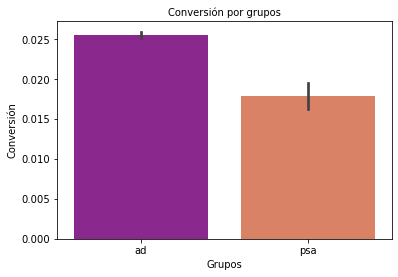

In [27]:
#Paso 4: Prueba de hipótesis:
#Análisis visual:


sns.barplot(x="test_group", y="converted", data=df,  palette = "plasma")


plt.xlabel('Grupos')
plt.ylabel('Conversión')
plt.title('Conversión por grupos', fontsize = 10);


In [28]:
#Tabla de contingencia:

tabla_contin = pd.crosstab(df['test_group'], df['converted'])
tabla_contin

converted,False,True
test_group,,
ad,550154,14423
psa,23104,420


In [30]:
#Prueba de proporciones: 

chi2, p_value, _, _ = chi2_contingency(tabla_contin)

alpha = 0.05

if p_value < alpha:
    print("Hay una diferencia significativa en la tasa de conversión entre el Grupo de Control y el Grupo de Prueba.")


else: 
    print("No hay evidencia de una diferencia significativa en la tasa de conversión entre los grupos.")


Hay una diferencia significativa en la tasa de conversión entre el Grupo de Control y el Grupo de Prueba.


*Al ser el valor p menor que un umbral predefinido (0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.*   


*Esto quiere decir que según los resultados existe una evidencia estadística para afirmar que el nuevo anuncio cumple los efectos deseados y se debería cambiar a la nueva versión.*

### Ejercicio 2:

En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

- Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.   
- Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.   
- Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras.   
- Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.   
- Análisis de resultados:   
    - Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.   
    - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.   
- Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [ ]:
#Paso 1: Preparación de los datos.
#En el ejercicio 1 ya hemos visto que los datos estaban bien. 

In [ ]:
#Paso 2: Definición de las hipótesis.
# Hipótesis nula (H0): No hay diferencia significativa en el promedio de anuncios vistos entre los grupos de prueba "ad" y "psa".
# Hipótesis alternativa (H1): Existe una diferencia significativa en el promedio de anuncios vistos entre los grupos de prueba "ad" y "psa".

In [36]:
#Paso 3: Prueba de hipótesis
#Separamos los dos grupos: 

grupo_ad = df[df['test_group'] == 'ad']
grupo_psa = df[df['test_group'] == 'psa']

#Comprobar la normalidad de los datos con Shapiro:

#Filtramos por total_ads:
ads_ad = grupo_ad['total_ads']
ads_psa = grupo_psa['total_ads']

statistic_ad, p_value_ad = shapiro(ads_ad)
statistic_psa, p_value_psa = shapiro(ads_psa)

print("Grupo 'AD':")
print("Estadística de Shapiro-Wilk:", statistic_ad)
print("Valor p:", p_value_ad)
if p_value_ad > 0.05:
    print("Los datos siguen una distribución normal.")
else:
    print("Los datos no siguen una distribución normal.")

print('-----')
print("Grupo 'PSA':")
print("Estadística de Shapiro-Wilk:", statistic_psa)
print("Valor p:", p_value_psa)
if p_value_psa > 0.05:
    print("Los datos siguen una distribución normal.")
else:
    print("Los datos no siguen una distribución normal.")



Grupo 'AD':
Estadística de Shapiro-Wilk: 0.47883927822113037
Valor p: 0.0
Los datos no siguen una distribución normal.
-----
Grupo 'PSA':
Estadística de Shapiro-Wilk: 0.515900731086731
Valor p: 0.0
Los datos no siguen una distribución normal.


In [40]:
#Al no seguir una distribución normal debemos realizar el test de Mann-Whitney
#Utilizamos el filtrado por total de anuncios: 

statistic, p_value_ = mannwhitneyu(ads_ad, ads_psa)


print("Estadística U de Mann-Whitney:", statistic)
print("Valor p:", p_value)


if p_value > 0.05:
    print("No hay diferencias significativas entre las medianas de las muestras.")
else:
    print("Hay diferencias significativas entre las medianas de las muestras.")


Estadística U de Mann-Whitney: 6808288222.0
Valor p: 4.6909108547205694e-11
Hay diferencias significativas entre las medianas de las muestras.


*Al haber diferencias significativas entre ambas muestras*